In [2]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, UpSampling2D, Concatenate, MaxPooling2D, MaxPool2D
from keras.layers import Dense, Activation, Flatten, Input
from keras.optimizers import SGD, Adam, Adadelta, Adagrad



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import matplotlib.pyplot as plt

def show_training_examples(train_images, noisy_images):
    num_examples = len(train_images)

    fig, axes = plt.subplots(nrows=num_examples, ncols=2, figsize=(10, 10))

    for i in range(num_examples):
        axes[i, 0].imshow(train_images[i])
        axes[i, 0].set_title('Training Image')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(noisy_images[i])
        axes[i, 1].set_title('Noisy Image')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

In [4]:
train_folder = '/content/drive/MyDrive/DRDO/train'
test_folder = '/content/drive/MyDrive/DRDO/test'
val_folder = '/content/drive/MyDrive/DRDO/val'

In [5]:
image_height = 128
image_width = 128

In [6]:
def preprocess_image(image):
    # image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = cv2.resize(image, (image_height, image_width))
    image = image.astype('float32') / 255.0
    return image

In [7]:
# Load the dataset
def load_dataset(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        image = cv2.imread(img_path)
        image = preprocess_image(image)
        images.append(image)
    return np.array(images)

In [8]:
# Generate noisy images by adding Gaussian noise
def add_gaussian_noise(image):
    noise = np.random.normal(0, 0.1, image.shape)
    noisy_image = np.clip(image + noise, 0, 1)
    return noisy_image

In [9]:
# Generate pairs of noisy and clean images for training
def generate_training_data(clean_images):
    noisy_images = []
    clean_images_resized = []
    for clean_image in clean_images:
        noisy_image = add_gaussian_noise(clean_image)
        resized_clean_image = cv2.resize(clean_image, (image_height, image_width))
        noisy_images.append(noisy_image)
        clean_images_resized.append(resized_clean_image)
    return np.array(noisy_images), np.array(clean_images_resized)

In [10]:
# Load and preprocess the training, validation, and testing datasets
train_images = load_dataset(train_folder)
test_images = load_dataset(test_folder)
val_images = load_dataset(val_folder)

In [11]:
# Generate pairs of noisy and clean training images
train_noisy_images, train_clean_images = generate_training_data(train_images)


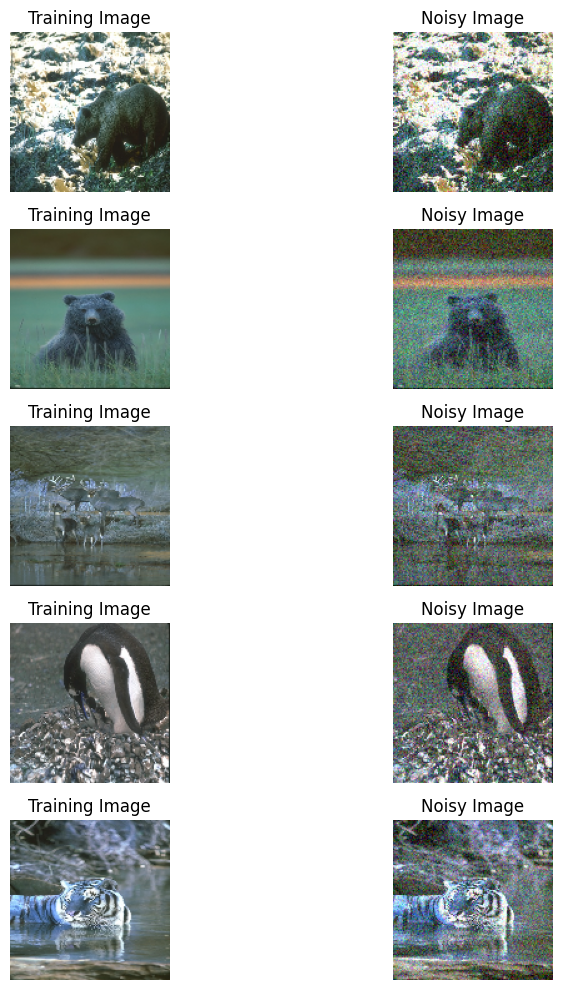

In [12]:
show_training_examples(train_clean_images[:5], train_noisy_images[:5])

In [13]:
# Define the CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(image_height, image_width, 3)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 256)     295168    
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 3)       6915      
                                                                 
Total params: 395331 (1.51 MB)
Trainable params: 395331 (1.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
# Compile the model with an initial learning rate
initial_learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
model.compile(optimizer=optimizer, loss='mean_squared_error')


In [16]:
val_noisy_images, val_clean_images = generate_training_data(val_images)

In [18]:
# Train the model
history = model.fit(train_noisy_images, train_clean_images, validation_data=(val_noisy_images, val_clean_images), epochs=50, batch_size=10)


Epoch 1/50
20/20 [==============================] - 2s 100ms/step - loss: 0.0356 - val_loss: 0.0180
Epoch 2/50
20/20 [==============================] - 2s 86ms/step - loss: 0.0124 - val_loss: 0.0098
Epoch 3/50
20/20 [==============================] - 2s 91ms/step - loss: 0.0081 - val_loss: 0.0061
Epoch 4/50
20/20 [==============================] - 2s 92ms/step - loss: 0.0056 - val_loss: 0.0047
Epoch 5/50
20/20 [==============================] - 2s 87ms/step - loss: 0.0044 - val_loss: 0.0041
Epoch 6/50
20/20 [==============================] - 2s 86ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 7/50
20/20 [==============================] - 2s 90ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 8/50
20/20 [==============================] - 2s 87ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 9/50
20/20 [==============================] - 2s 90ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 10/50
20/20 [==============================] - 2s 87ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 11

In [19]:
test_noisy_images, test_clean_images = generate_training_data(test_images)
evaluation = model.evaluate(test_noisy_images, test_clean_images)
print("Test Loss:", evaluation)


7/7 [==============================] - 5s 206ms/step - loss: 0.0020
Test Loss: 0.0020339475013315678


In [20]:
# Perform denoising on test images
denoised_images = model.predict(test_noisy_images)


7/7 [==============================] - 0s 60ms/step


In [22]:
example_path='/content/example.jpg'
examples=[]
example = cv2.imread(example_path)
example = preprocess_image(example)
examples.append(example)
examples=np.array(examples)

In [23]:
ans=model.predict(examples)

1/1 [==============================] - 0s 343ms/step


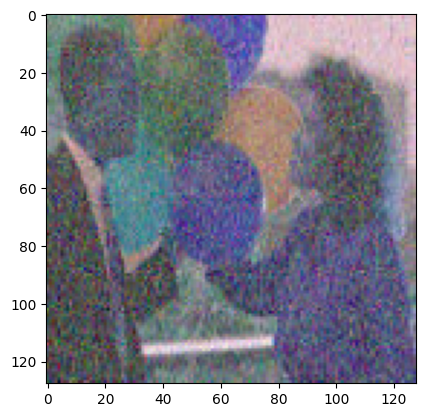

In [24]:
plt.imshow(examples[0])

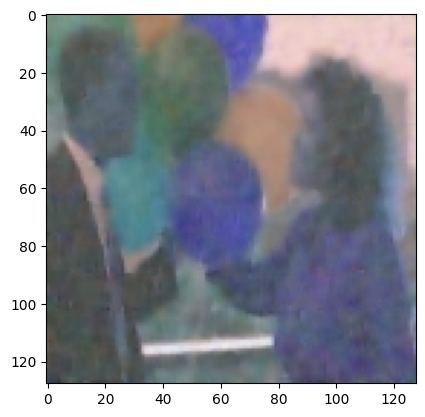

In [25]:
plt.imshow(ans[0])

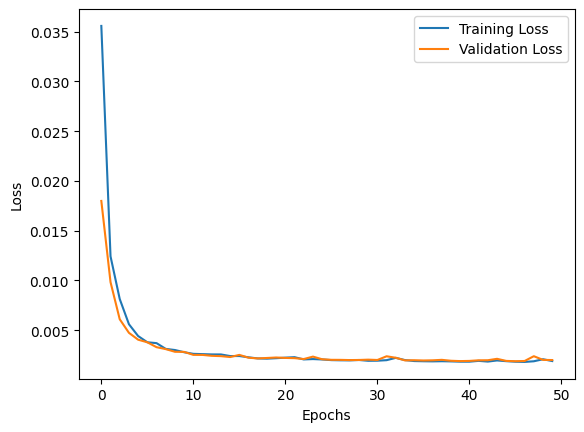

In [26]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [27]:
def autoencoder():

    input_img = Input(shape=(128,128,3), name='image_input')

    #enoder
    x = Conv2D(64, (5,5), activation='relu', padding='same', name='Conv1')(input_img)
    x = MaxPooling2D((2,2), padding='same', name='pool1')(x)
    x = Conv2D(128, (3,3), activation='relu', padding='same', name='Conv2')(x)
    x = MaxPooling2D((2,2), padding='same', name='pool2')(x)

    #decoder
    x = Conv2D(128, (3,3), activation='relu', padding='same', name='Conv3')(x)
    x = UpSampling2D((2,2), name='upsample1')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv4')(x)
    x = UpSampling2D((2,2), name='upsample2')(x)
    x = Conv2D(3, (5,5), activation='sigmoid', padding='same', name='Conv5')(x)

    #model
    autoencoder = Model(inputs=input_img, outputs=x)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

    return autoencoder

In [28]:
# Compile the model
autoencodermodel = autoencoder()
autoencodermodel.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 128, 128, 3)]     0         
                                                                 
 Conv1 (Conv2D)              (None, 128, 128, 64)      4864      
                                                                 
 pool1 (MaxPooling2D)        (None, 64, 64, 64)        0         
                                                                 
 Conv2 (Conv2D)              (None, 64, 64, 128)       73856     
                                                                 
 pool2 (MaxPooling2D)        (None, 32, 32, 128)       0         
                                                                 
 Conv3 (Conv2D)              (None, 32, 32, 128)       147584    
                                                                 
 upsample1 (UpSampling2D)    (None, 64, 64, 128)       0     

In [29]:
# Train the model
history2 = autoencodermodel.fit(train_noisy_images, train_clean_images, epochs=20, batch_size=10, validation_data=(val_noisy_images, val_clean_images))

Epoch 1/20
20/20 [==============================] - 4s 43ms/step - loss: 0.0423 - accuracy: 0.4819 - val_loss: 0.0306 - val_accuracy: 0.6133
Epoch 2/20
20/20 [==============================] - 1s 28ms/step - loss: 0.0242 - accuracy: 0.6272 - val_loss: 0.0180 - val_accuracy: 0.5772
Epoch 3/20
20/20 [==============================] - 1s 32ms/step - loss: 0.0150 - accuracy: 0.6809 - val_loss: 0.0153 - val_accuracy: 0.6764
Epoch 4/20
20/20 [==============================] - 1s 29ms/step - loss: 0.0130 - accuracy: 0.7231 - val_loss: 0.0131 - val_accuracy: 0.6242
Epoch 5/20
20/20 [==============================] - 1s 32ms/step - loss: 0.0111 - accuracy: 0.7502 - val_loss: 0.0099 - val_accuracy: 0.7594
Epoch 6/20
20/20 [==============================] - 1s 32ms/step - loss: 0.0097 - accuracy: 0.8029 - val_loss: 0.0095 - val_accuracy: 0.8002
Epoch 7/20
20/20 [==============================] - 1s 29ms/step - loss: 0.0088 - accuracy: 0.8308 - val_loss: 0.0087 - val_accuracy: 0.8124
Epoch 8/20
20

In [30]:
denoised_images2 = autoencodermodel.predict(test_noisy_images)

7/7 [==============================] - 1s 68ms/step


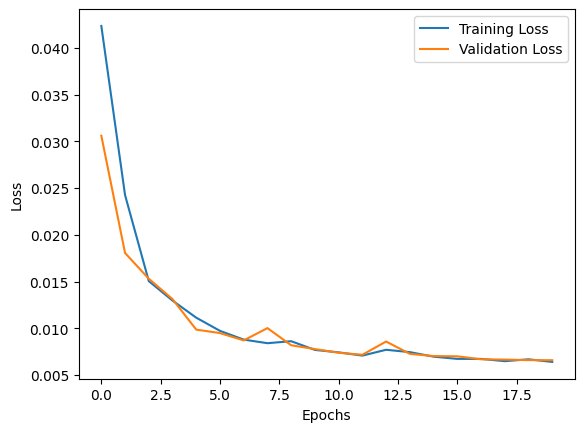

In [31]:
# Plot training and validation loss
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


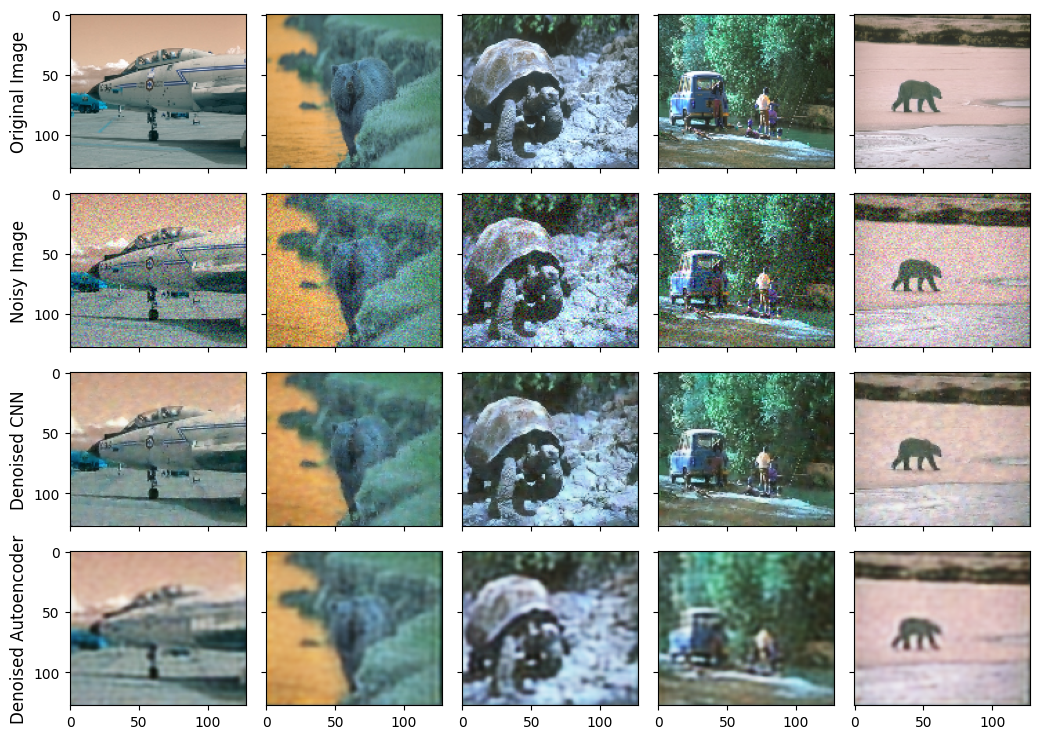

In [32]:
import numpy as np
import matplotlib.pyplot as plt

def plot_predictions(test_images, y_true, y_pred, y2_pred):
    labels = ['Original Image', 'Noisy Image', 'Denoised CNN', 'Denoised Autoencoder']
    f, ax = plt.subplots(4, 5)
    f.set_size_inches(10.5, 7.5)
    for i in range(5):
        ax[0][i].imshow(np.reshape(test_images[i], (128, 128,3)), aspect='auto', cmap='gray')
        ax[1][i].imshow(np.reshape(y_true[i], (128, 128,3)), aspect='auto', cmap='gray')
        ax[2][i].imshow(np.reshape(y_pred[i], (128, 128,3)), aspect='auto', cmap='gray')
        ax[3][i].imshow(np.reshape(y2_pred[i], (128, 128,3)), aspect='auto', cmap='gray')

    for a in ax.flat:
        a.label_outer()

    for ax_row, label in zip(ax, labels):
        ax_row[0].set_ylabel(label, rotation=90, size='large')

    plt.tight_layout()
    plt.show()


plot_predictions(test_images[:5],test_noisy_images[:5], denoised_images[:5], denoised_images2[:5])

In [33]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
def calculate_psnr(image1, image2):
    psnr = peak_signal_noise_ratio(image1, image2)
    return psnr

def calculate_ssim(image1, image2):
    ssim = structural_similarity(image1, image2, multichannel=True)
    return ssim


<ipython-input-33-2b363c73fe6e>:3: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(image1, image2)
<ipython-input-33-2b363c73fe6e>:7: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = structural_similarity(image1, image2, multichannel=True)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


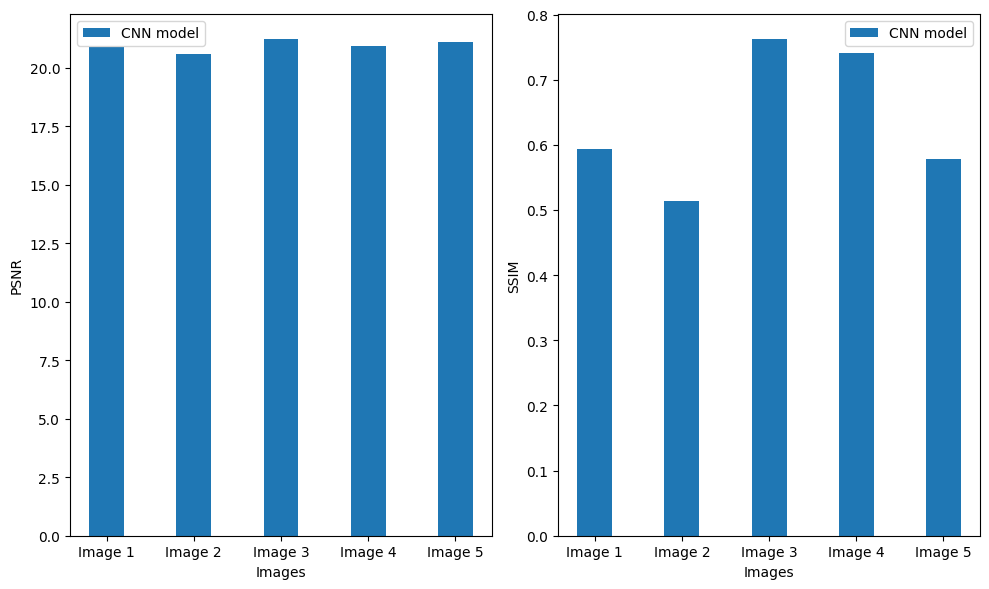

In [34]:
# Calculating PSNR and SSIM for the denoised CNN images
model_psnr_values = []
model_ssim_values = []

for i in range(len(test_noisy_images[:5])):
    original_image = test_noisy_images[i].squeeze()  # Remove the channel dimension
    reconstructed_image = denoised_images[i].squeeze()  # Remove the channel dimension

    model_psnr = calculate_psnr(original_image, reconstructed_image)
    model_ssim = calculate_ssim(original_image, reconstructed_image)

    model_psnr_values.append(model_psnr)
    model_ssim_values.append(model_ssim)


# Plot the findings
labels = ['Image 1', 'Image 2', 'Image 3', 'Image 4', 'Image 5']
x = np.arange(len(labels))

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.bar(x, model_psnr_values, width=0.4, label='CNN model')

plt.xlabel('Images')
plt.ylabel('PSNR')

plt.xticks(x, labels)
plt.legend()

plt.subplot(1, 2, 2)
plt.bar(x, model_ssim_values, width=0.4, label='CNN model')
plt.xlabel('Images')
plt.ylabel('SSIM')
plt.xticks(x, labels)
plt.legend()

plt.tight_layout()
plt.show()


<ipython-input-33-2b363c73fe6e>:3: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(image1, image2)
<ipython-input-33-2b363c73fe6e>:7: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = structural_similarity(image1, image2, multichannel=True)


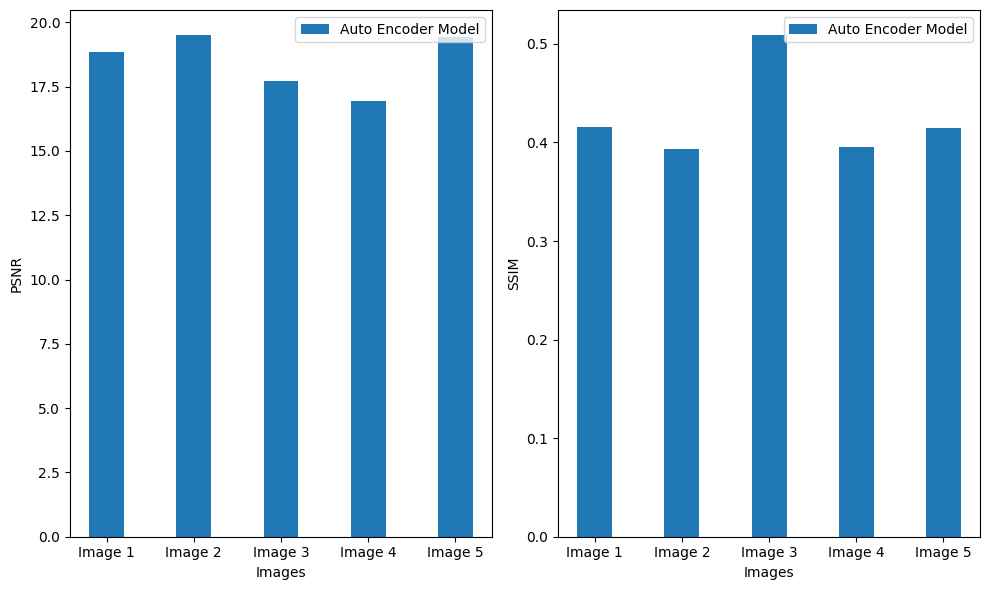

In [35]:
# Calculating PSNR and SSIM for the reconstructed images
model_psnr_values = []
model_ssim_values = []

for i in range(len(test_noisy_images[:5])):
    original_image = test_noisy_images[i].squeeze()  # Remove the channel dimension
    reconstructed_image = denoised_images2[i].squeeze()  # Remove the channel dimension

    model_psnr = calculate_psnr(original_image, reconstructed_image)
    model_ssim = calculate_ssim(original_image, reconstructed_image)

    model_psnr_values.append(model_psnr)
    model_ssim_values.append(model_ssim)


# Plot the findings
labels = ['Image 1', 'Image 2', 'Image 3', 'Image 4', 'Image 5']
x = np.arange(len(labels))

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.bar(x, model_psnr_values, width=0.4, label='Auto Encoder Model')

plt.xlabel('Images')
plt.ylabel('PSNR')

plt.xticks(x, labels)
plt.legend()

plt.subplot(1, 2, 2)
plt.bar(x, model_ssim_values, width=0.4, label='Auto Encoder Model')
plt.xlabel('Images')
plt.ylabel('SSIM')
plt.xticks(x, labels)
plt.legend()

plt.tight_layout()
plt.show()


<ipython-input-33-2b363c73fe6e>:3: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(image1, image2)
<ipython-input-33-2b363c73fe6e>:7: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = structural_similarity(image1, image2, multichannel=True)


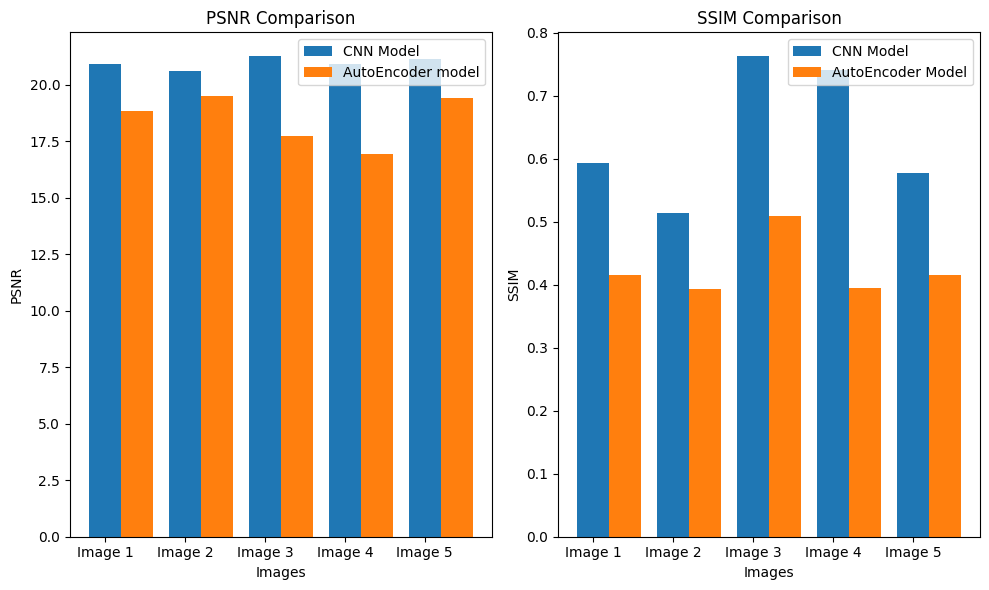

In [36]:
#Comparison between the two models

# Calculating PSNR and SSIM for the denoised CNN images
model_psnr_values = []
model_ssim_values = []

for i in range(len(test_noisy_images[:5])):
    original_image = test_noisy_images[i].squeeze()  # Remove the channel dimension
    reconstructed_image = denoised_images[i].squeeze()  # Remove the channel dimension

    model_psnr = calculate_psnr(original_image, reconstructed_image)
    model_ssim = calculate_ssim(original_image, reconstructed_image)

    model_psnr_values.append(model_psnr)
    model_ssim_values.append(model_ssim)

# Calculating PSNR and SSIM for the reconstructed Autoencoder images
autoencoder_psnr_values = []
autoencoder_ssim_values = []

for i in range(len(test_noisy_images[:5])):
    original_image2 = test_noisy_images[i].squeeze()  # Remove the channel dimension
    reconstructed_image2 = denoised_images2[i].squeeze() # Remove the channel dimension

    autoencoder_psnr = calculate_psnr(original_image2, reconstructed_image2)
    autoencoder_ssim = calculate_ssim(original_image2, reconstructed_image2)

    autoencoder_psnr_values.append(autoencoder_psnr)
    autoencoder_ssim_values.append(autoencoder_ssim)

# Plot the comparison
labels = ['Image 1', 'Image 2', 'Image 3', 'Image 4', 'Image 5']
x = np.arange(len(labels))

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.bar(x, model_psnr_values, width=0.4, label='CNN Model')
plt.bar(x+0.4, autoencoder_psnr_values, width=0.4, label='AutoEncoder model')
plt.xlabel('Images')
plt.ylabel('PSNR')
plt.title('PSNR Comparison')
plt.xticks(x, labels)
plt.legend()

plt.subplot(1, 2, 2)
plt.bar(x, model_ssim_values, width=0.4, label='CNN Model')
plt.bar(x+0.4, autoencoder_ssim_values, width=0.4, label='AutoEncoder Model')
plt.xlabel('Images')
plt.ylabel('SSIM')
plt.title('SSIM Comparison')
plt.xticks(x, labels)
plt.legend()

plt.tight_layout()
plt.show()

In [37]:
sum(model_psnr_values)/len(model_psnr_values)

20.96018226646907